In [4]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import Binarizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,recall_score,roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def get_clf_eval(y_test,pred):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)
  roc_score = roc_auc_score(y_test,pred)
  # F1 스코어 추가
  f1 = f1_score(y_test,pred)
  print('오차행렬')
  print(confusion)
  # F1 스코어 print 추가
  print('정확도:{0:4f},정밀도:{1:4f},재현율:{2:4f},F1:{3:4f},ROC AUC값:{4:4f}'.format(accuracy,precision,recall,f1,roc_score))

def precision_recall_curve_plot(y_test,pred_proba_c1):
  #임계값(threshold) ndarray와 임계값에 따른 정밀도, 재현율 ndarray추출.
  precisions, recalls,thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 임계값, Y축을 정밀도 및 재현율 값으로 각각 plot을 그림.
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary],linestyle='--',label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

  #threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  
  #label 및 legend 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend();plt.grid()
  plt.show()

def get_eval_by_threshold(y_test,pred_proba_c1,thresholds):
  # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임계값:',custom_threshold)
    get_clf_eval(y_test,custom_predict)

In [6]:
diabetes = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
diabetes['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [8]:
# feature의 타입과 Null 개수 파악
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
# 독립변수, 종속변수 추출
X = diabetes.iloc[:,:-1]
Y = diabetes.iloc[:,-1]

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,
                                                 random_state=156,stratify=Y)

#로지스틱 회귀로 학습, 예측 및 평가
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차행렬
[[88 12]
 [23 31]]
정확도:0.772727,정밀도:0.720930,재현율:0.574074,F1:0.639175,ROC AUC값:0.727037


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


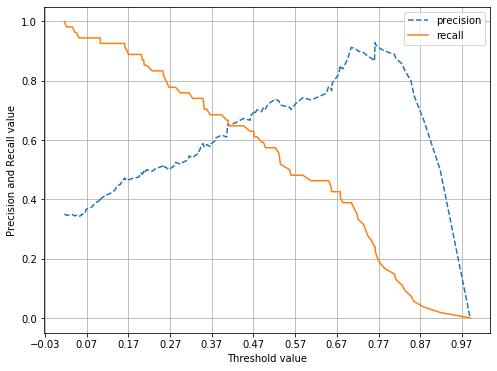

In [10]:
# 정밀도 재현율 곡선을 보고 임곗값별 정밀도와 재현율 값의 변화 확인
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1] #레이블 값이 1일때 예측 확률 추출
precision_recall_curve_plot(y_test,pred_proba_c1)

여전히 정밀도, 재현율 두 지표 모두 낮음.(겹치는 곳에서 둘다 0.7이 안됨)

어느 정도 데이터에 대한 점검이 필요함.

In [11]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


신체정보에 관한 데이터에 왜 0값이 있지??

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

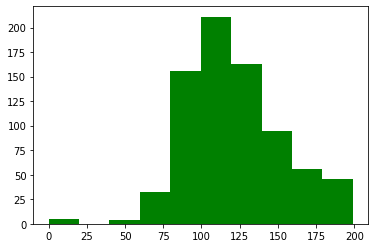

In [12]:
plt.hist(diabetes['Glucose'],bins=10,color='Green')

In [13]:
# min() 값이 0으로 되어 있는 피처에 대해 0 값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인해보자.
'''BloodPressure	SkinThickness	Insulin	BMI'''
zero_features =['BloodPressure','SkinThickness','Insulin','BMI']

#전체 데이터 건수
total_count=len(diabetes)

#피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
  zero_count = diabetes[diabetes[feature]==0][feature].count()
  print('{0} 0건수는 {1}, 퍼센트는 {2:2f}%'.format(feature,zero_count,
                                            100*zero_count/total_count))

BloodPressure 0건수는 35, 퍼센트는 4.557292%
SkinThickness 0건수는 227, 퍼센트는 29.557292%
Insulin 0건수는 374, 퍼센트는 48.697917%
BMI 0건수는 11, 퍼센트는 1.432292%


SkinThickness와 Insulin의 0값이 상당히 많음. 이를 평균으로 대체하자.

In [14]:
# zeros_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes[zero_features].mean()
print(mean_zero_features)

diabetes[zero_features] = diabetes[zero_features].replace(0,mean_zero_features)

BloodPressure    69.105469
SkinThickness    20.536458
Insulin          79.799479
BMI              31.992578
dtype: float64


In [15]:
X = diabetes.iloc[:,:-1]
y = diabetes.iloc[:,-1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,
                                                 random_state=156,stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

print('\n')
'''
성능 수치가 일정 수준 개선됨, 여전히 재현율 상태는 낮은 상태.
임계값을 변화시키면서 성능 개선 수치를 확인해보자.
'''

오차행렬
[[90 10]
 [22 32]]
정확도:0.792208,정밀도:0.761905,재현율:0.592593,F1:0.666667,ROC AUC값:0.746296




'\n성능 수치가 일정 수준 개선됨, 여전히 재현율 상태는 낮은 상태.\n임계값을 변화시키면서 성능 개선 수치를 확인해보자.\n'

In [16]:
# 임계값 0.3에서 0.5까지 0.03씩 변화시키면서 재현율과 다른 평가 지표의 값 변화 출력
thresholds = [0.3,0.33,0.36,0.39,0.42,0.45,0.48,0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임계값: 0.3
오차행렬
[[66 34]
 [13 41]]
정확도:0.694805,정밀도:0.546667,재현율:0.759259,F1:0.635659,ROC AUC값:0.709630
임계값: 0.33
오차행렬
[[71 29]
 [13 41]]
정확도:0.727273,정밀도:0.585714,재현율:0.759259,F1:0.661290,ROC AUC값:0.734630
임계값: 0.36
오차행렬
[[76 24]
 [17 37]]
정확도:0.733766,정밀도:0.606557,재현율:0.685185,F1:0.643478,ROC AUC값:0.722593
임계값: 0.39
오차행렬
[[78 22]
 [18 36]]
정확도:0.740260,정밀도:0.620690,재현율:0.666667,F1:0.642857,ROC AUC값:0.723333
임계값: 0.42
오차행렬
[[84 16]
 [20 34]]
정확도:0.766234,정밀도:0.680000,재현율:0.629630,F1:0.653846,ROC AUC값:0.734815
임계값: 0.45
오차행렬
[[85 15]
 [20 34]]
정확도:0.772727,정밀도:0.693878,재현율:0.629630,F1:0.660194,ROC AUC값:0.739815
임계값: 0.48
오차행렬
[[88 12]
 [21 33]]
정확도:0.785714,정밀도:0.733333,재현율:0.611111,F1:0.666667,ROC AUC값:0.745556
임계값: 0.5
오차행렬
[[90 10]
 [22 32]]
정확도:0.792208,정밀도:0.761905,재현율:0.592593,F1:0.666667,ROC AUC값:0.746296


# 앙상블 적용

## Voting

In [17]:
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear')
rnd_clf = RandomForestClassifier(n_estimators=200,max_depth=5)
svm_clf = SVC(probability=True,gamma='auto')

voting_clf_hard = VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='hard')

voting_clf_soft = VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='soft')


voting_clf_hard.fit(X_train,y_train)
voting_clf_soft.fit(X_train,y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=Non...
                                        

In [18]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svm_clf,voting_clf_hard,voting_clf_soft):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__)
  get_clf_eval(y_test,y_pred)
  print('-------------------------------------------')

LogisticRegression
오차행렬
[[90 10]
 [22 32]]
정확도:0.792208,정밀도:0.761905,재현율:0.592593,F1:0.666667,ROC AUC값:0.746296
-------------------------------------------
RandomForestClassifier
오차행렬
[[87 13]
 [24 30]]
정확도:0.759740,정밀도:0.697674,재현율:0.555556,F1:0.618557,ROC AUC값:0.712778
-------------------------------------------
SVC
오차행렬
[[85 15]
 [24 30]]
정확도:0.746753,정밀도:0.666667,재현율:0.555556,F1:0.606061,ROC AUC값:0.702778
-------------------------------------------
VotingClassifier
오차행렬
[[89 11]
 [23 31]]
정확도:0.779221,정밀도:0.738095,재현율:0.574074,F1:0.645833,ROC AUC값:0.732037
-------------------------------------------
VotingClassifier
오차행렬
[[88 12]
 [24 30]]
정확도:0.766234,정밀도:0.714286,재현율:0.555556,F1:0.625000,ROC AUC값:0.717778
-------------------------------------------


왜 VotingClassifier의 성능이 더 안좋게 나오는 것일까..?

In [19]:
for clf in (log_clf,rnd_clf,svm_clf,voting_clf_hard,voting_clf_soft):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.7922077922077922
RandomForestClassifier 0.7597402597402597
SVC 0.7467532467532467
VotingClassifier 0.7857142857142857
VotingClassifier 0.7662337662337663


보팅으로 여러 개의 기반 분류기를 결합한다고 해서 무조건 기반 분류기보다 예측 성능이 향상되지는 않는다.

 **데이터의 특성과 분포 등 다양한 요건에 따라 오히려 기반 분류기 중 가장 좋은 분류기의 성능이 보팅했을 때보다 나을 수도 있다.**

편향- 분산 트레이드오프는 ML 모델이 극복해야할 중요 과제임.
- 보팅과 스태킹 등은 서로 다른 알고리즘을 기반으로 하고 있지만, 배깅과 부스팅은 대부분 결정트리 알고리즘을 기반으로 한다.
- 결정트리 알고리즘은 쉽고 직관적인 분류 기준을 가지고 있지만 정확한 예측을 위해 학습 데이터의 예외 상황에 집착한 나머지 오히려 과적합이 발생할 가능성이 높음 -> 그 단점을 보완하기 위해 앙상블 방법을 사용하는 것

*`-from 파이썬 머신러닝 완벽가이드-`*

## 배깅, 페이스팅
- 같은 알고리즘을 사용하지만 훈련 세트의 서브셋을 무작위로 구성하여 분류기(모델)을 각기 다르게 학습시킴.
  - 배깅: 중복허용
  - 페이스팅: 중복허용 x
  - 배깅이 페이스팅보다 편향이 조금 더 높으나 예측기들간의 상관관계가 낮아짐 -> 앙상블의 분산 감소

In [29]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


for bootstrap in [True,False]:  
  bag_clf = BaggingClassifier(
  DecisionTreeClassifier(max_depth=10),n_estimators=1000,
  max_samples = 0.7, bootstrap= bootstrap, n_jobs=-1) 
  
  bag_clf.fit(X_train,y_train)
  y_pred = bag_clf.predict(X_test)
  
  print(bag_clf.__class__.__name__)
  get_clf_eval(y_test,y_pred)

BaggingClassifier
오차행렬
[[86 14]
 [22 32]]
정확도:0.766234,정밀도:0.695652,재현율:0.592593,F1:0.640000,ROC AUC값:0.726296
BaggingClassifier
오차행렬
[[83 17]
 [23 31]]
정확도:0.740260,정밀도:0.645833,재현율:0.574074,F1:0.607843,ROC AUC값:0.702037


### oob 평가 (out-of-bag)
- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음.
- 평균적으로 각 예측기에 64%만 채택 -> 나머지 36%의 데이터셋(예측기마다 남겨진 oob는 다름)을 검증 세트나 교차 검증을 사용하지 않고 oob 샘플을 사용해 평가할 수 있음.

In [30]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=10),n_estimators=1000,
    max_samples = 0.7, bootstrap= True,oob_score=True,n_jobs=-1)
  
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)
  
print(bag_clf.__class__.__name__)
#get_clf_eval(y_test,y_pred)
bag_clf.oob_score_

BaggingClassifier


0.7671009771986971

## 랜덤포레스트
- 배깅 방법을 적용한 결정 트리의 앙상블

In [33]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=1000,max_leaf_nodes=16,n_jobs=-1)
rnd_clf.fit(X_train,y_train)

y_pred = rnd_clf.predict(X_test)
  
print(rnd_clf.__class__.__name__)
get_clf_eval(y_test,y_pred)

RandomForestClassifier
오차행렬
[[88 12]
 [23 31]]
정확도:0.772727,정밀도:0.720930,재현율:0.574074,F1:0.639175,ROC AUC값:0.727037
